<a href="https://colab.research.google.com/github/Samarth745/Credit-Card-Risk-Analysis/blob/main/CR_VER3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CREDIT RISK PORTFOLIO

## Import Data and Libraries

In [1]:
#@title IMPORTS
## Installs

## Important Libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency

## Display Settings
from IPython.display import display, clear_output
import ipywidgets as widgets
pd.set_option('display.max_columns', None)

In [2]:
#@title GET DATA FROM KAGGLE
!pip install kaggle
api_command = "kaggle datasets download -d venkatasubramanian/credit-eda-case-study"
# Step 2: Upload Kaggle API key
from google.colab import files
files.upload()

# Step 3: Make a directory for the Kaggle configuration and move the key there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Step 4: Set the permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

# Step 5: Download the dataset using the Kaggle API command
!kaggle datasets download -d venkatasubramanian/credit-eda-case-study

# Step 6: Unzip the dataset if needed
!unzip credit-eda-case-study.zip
clear_output()

In [3]:
!ls

 application_data.csv	   'Credit EDA Case Study.pdf'	 previous_application.csv
 columns_description.xlsx   credit-eda-case-study.zip	 sample_data


In [4]:
#@title READING DATA
app_data = pd.read_csv("application_data.csv")
prev_app = pd.read_csv("previous_application.csv")
col_desc = pd.read_excel("columns_description.xlsx")

## Understanding Data

1. `application_data`
 Contains detailed information about the current loan applications. Each row represents a unique loan application.


 - Demographgy: Gender, Days Since Birth, Marital Status, Owned Assets, Count of Children, Education
 - Employment and Income: Days Employed, Occupation Type, Income.
 - Financial Obligations and credits: Amount credit, Amount Anuity, Amount Grat, Amount goods price etc.
 - Social and Ecomic conditions: Ratings of Application region, flag indicating if the applicant lives in different city,

2. `previous_application` Contains records of past loan applications for each applicant. This historical data is essential for understanding the applicant's credit behavior and risk profile.
- Clients Loan Details: Status, amount credit, Applications count etc
- Data provision: The data client provided in previous applications binary.
- Resedential Information

FLAG_MOBIL, WEEKDAY_APPR_PROCESS_START, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, LIVE_REGION_NOT_WORK_REGION, FLOORSMAX_AVG: Seems unnecessary to the prject as of now unless Linked to Specific Rates


In [40]:
#@title HELPER FUNCTION
!pip install textwrap
import textwrap
"""
Considering High No of features in the data set,
I am creating this helper function that prints the description of column.
"""
def print_info(column_name):
  return (textwrap.fill(
      col_desc[
      col_desc["Row"].str.lower()==column_name.lower()]["Description"].values[0],width=50))


ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap


In [6]:
#@title Get Column Detail
print_info("AMT_GOODS_PRICE")

For consumer loans it is the price of the goods
for which the loan is given


### Application Data

In [18]:
#@title Entries and Features
print(f""" The total Entries in the data are {app_data.shape[0]}.
The total number of features in the data are {app_data.shape[1]}
""")

 The total Entries in the data are 307511. 
The total number of features in the data are 122



Text(0.5, 1.0, 'Missing values Distribution')

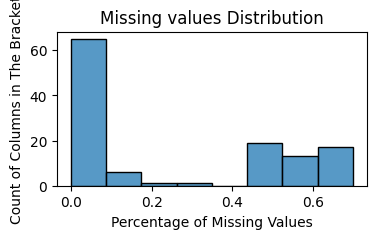

In [66]:
#@title Missing values Distribution
plt.figure(figsize=(4,2))
sns.histplot(app_data.isnull().sum()/app_data.shape[0])
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Count of Columns in The Bracket")
plt.title("Missing values Distribution")

In [ ]:
#@title Missing Values Observations

 `Missing Values Observations`
- Most columns with missing values have between 0% and 10% missing data, so we can fill in those missing values without much trouble.

- Some columns have over 40% missing values. Given the importance of accuracy for this project, we may need to remove these columns.

In [50]:
#@title Missing Values > 40% columns
for column in app_data.isnull().sum()[(app_data.isnull().sum()/app_data.shape[0]).apply(lambda x:x>0.4)].reset_index()["index"]:
  print(f"ColumnName {column}")
  print(f" Info {print_info(column)}")
  print("--------------------------------------------------------------")

ColumnName OWN_CAR_AGE
 Info Age of client's car
--------------------------------------------------------------
ColumnName EXT_SOURCE_1
 Info Normalized score from external data source
--------------------------------------------------------------
ColumnName APARTMENTS_AVG
 Info Normalized information about building where the
client lives, What is average (_AVG suffix), modus
(_MODE suffix), median (_MEDI suffix) apartment
size, common area, living area, age of building,
number of elevators, number of entrances, state of
the building, number of floor
--------------------------------------------------------------
ColumnName BASEMENTAREA_AVG
 Info Normalized information about building where the
client lives, What is average (_AVG suffix), modus
(_MODE suffix), median (_MEDI suffix) apartment
size, common area, living area, age of building,
number of elevators, number of entrances, state of
the building, number of floor
--------------------------------------------------------------
Column

In [79]:
#@title Deleting Missing values > 40%
list_of_columns_to_delete = (app_data.isnull().sum()[app_data.isnull().sum()>app_data.shape[0]*0.39].index)
app_data.drop(columns = list_of_columns_to_delete, inplace=True)

In [80]:
#@title Data Info
app_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

In [81]:
#@title Data.Describe
app_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.068510e+05,246546.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,5.143927e-01,0.510853,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,1.910602e-01,0.194844,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000